this is my solution code to the titanic survived problem found on kaggle

In [5]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


oh we notice that almost 77% of the cabin are null values , some of the age values are also missing but we can solve that easily by imputing with the mean or using KNNimputing strategy , also we need to process the categorical features ,and finally its propablly a good idea to scale the features especially with models such as Logistic Regression or SVMs

In [7]:
train_processing = train.set_index('PassengerId')
#we dont need the name and cabin atrribute also (cabin has way too many missing values)
train_processing = train.drop(['Cabin', 'PassengerId', 'Name'], axis=1)
train_processing.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S


In [8]:
%pip install --upgrade scikit-learn



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


for the ticket attribute we will try to see its colleartion to find out if we should drop it or no

In [9]:
from sklearn.preprocessing import OneHotEncoder
# -------------------------------
# Extract prefix
train_prefix = train_processing.copy()
train_prefix['TicketPrefix'] = train_prefix['Ticket'].str.extract('([A-Za-z./]+)')
train_prefix['TicketPrefix'] = train_prefix['TicketPrefix'].fillna('None')

# One-hot encode the prefixes
ohe_ticket = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ticket_encoded = ohe_ticket.fit_transform(train_prefix[['TicketPrefix']])
ticket_encoded_df = pd.DataFrame(
    ticket_encoded,
    columns=ohe_ticket.get_feature_names_out(['TicketPrefix']),
    index=train_prefix.index
)

# Drop original Ticket and TicketPrefix and add encoded columns
train_ticket_prefix = pd.concat(
    [train_prefix.drop(columns=['Ticket', 'TicketPrefix']), ticket_encoded_df],
    axis=1
)


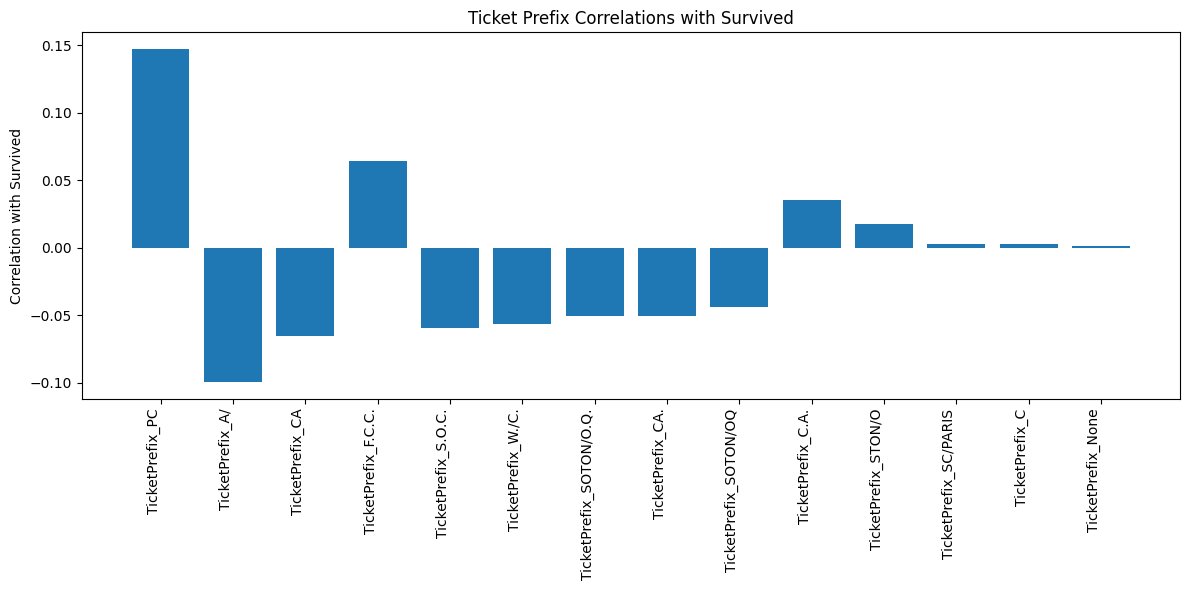

TicketPrefix_PC            0.147062
TicketPrefix_A/           -0.099372
TicketPrefix_CA           -0.064988
TicketPrefix_F.C.C.        0.064285
TicketPrefix_S.O.C.       -0.059292
TicketPrefix_W./C.        -0.056649
TicketPrefix_SOTON/O.Q.   -0.050661
TicketPrefix_CA.          -0.050661
TicketPrefix_SOTON/OQ     -0.044095
TicketPrefix_C.A.          0.035493
TicketPrefix_STON/O        0.017895
TicketPrefix_SC/PARIS      0.002496
TicketPrefix_C             0.002496
TicketPrefix_None          0.001492
Name: Survived, dtype: float64


In [10]:
import pandas as pd
import matplotlib.pyplot as plt   # ✔ FIXED

# 1️⃣ Select only numeric columns (all one-hot encoded prefixes are numeric)
numeric_cols = train_ticket_prefix.select_dtypes(include='number')

# 2️⃣ Compute correlation with Survived
prefix_corr = numeric_cols.corr()['Survived'].filter(like='TicketPrefix_')

# 3️⃣ Count occurrences of each prefix
prefix_counts = train_processing['Ticket'].str.extract('([A-Za-z./]+)')[0].fillna('None').value_counts()

# Keep prefixes with at least 5 passengers
valid_prefixes = prefix_counts[prefix_counts >= 5].index
prefix_corr_filtered = prefix_corr[["TicketPrefix_" + p for p in valid_prefixes if "TicketPrefix_" + p in prefix_corr.index]]

# 4️⃣ Sort
prefix_corr_filtered = prefix_corr_filtered.reindex(prefix_corr_filtered.abs().sort_values(ascending=False).index)

# 5️⃣ Plot
plt.figure(figsize=(12, 6))
plt.bar(prefix_corr_filtered.index, prefix_corr_filtered.values)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Correlation with Survived')
plt.title('Ticket Prefix Correlations with Survived')
plt.tight_layout()
plt.show()

# 6️⃣ Show values
print(prefix_corr_filtered)


okay so as we see most of the new features didnt have any importance , since i kinda want to have a simple dataset i will drop the entire column

In [11]:
train_processing = train_processing.drop(['Ticket'], axis=1)
train_processing.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


okay now that we knew what we need to drop and what we need to keep and also what type of processing we need to do its time to create some pipelines

In [18]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# -------------------------------------------
# 1. Drop unused columns (keep Survived separately)
# -------------------------------------------
X_train_raw = train.drop(columns=["Cabin", "Name", "Ticket", "PassengerId", "Survived"])
y_train = train["Survived"]  # target

# -------------------------------------------
# 2. Encode Sex manually
# -------------------------------------------
X_train_raw["Sex"] = X_train_raw["Sex"].map({"male": 1, "female": 0})

# -------------------------------------------
# 3. Feature groups
# -------------------------------------------
num_no_scale = ["SibSp", "Parch", "Pclass"]  # remove Survived
num_scaled = ["Age", "Fare"]
cat_features = ["Embarked"]

# -------------------------------------------
# 4. Pipelines
# -------------------------------------------
num_no_scale_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

num_scaled_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# -------------------------------------------
# 5. ColumnTransformer
# -------------------------------------------
preprocessor = ColumnTransformer([
    ("num_no_scale", num_no_scale_pipe, num_no_scale),
    ("num_scaled", num_scaled_pipe, num_scaled),
    ("cat", cat_pipe, cat_features)
], remainder="passthrough")   # keeps "Sex"

# -------------------------------------------
# 6. Fit-transform
# -------------------------------------------
X_prepared = preprocessor.fit_transform(X_train_raw)

# -------------------------------------------
# 7. Column names
# -------------------------------------------
embarked_cols = list(
    preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(["Embarked"])
)

final_columns = (
    num_no_scale      # 3
    + num_scaled      # 2
    + embarked_cols   # 3 (C, Q, S)
    + ["Sex"]         # 1
)  # TOTAL = 9 columns

# -------------------------------------------
# 8. Build DataFrame
# -------------------------------------------
train_prepared_df = pd.DataFrame(X_prepared, columns=final_columns)
train_prepared_df.head()


,SibSp,Parch,Pclass,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex
0,1.0,0.0,3.0,-0.565736,-0.502445,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.663861,0.786845,1.0,0.0,0.0,0.0
2,0.0,0.0,3.0,-0.258337,-0.488854,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.433312,0.420730,0.0,0.0,1.0,0.0
4,0.0,0.0,3.0,0.433312,-0.486337,0.0,0.0,1.0,1.0


now we will train diffrent models to choose the best one using cross validation also

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# 1️⃣ Features and target
X = train_prepared_df  # already only features, Survived is not included
y = y_train            # target

# 2️⃣ Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', gamma='scale', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# 3️⃣ Evaluate each classifier with 5-fold CV
results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    print(f"{name}: Mean Accuracy = {scores.mean():.4f} ± {scores.std():.4f}")

# 4️⃣ Show sorted results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
print("\n✅ Classifiers sorted by accuracy:")
for name, score in sorted_results.items():
    print(f"{name}: {score:.4f}")


Logistic Regression: Mean Accuracy = 0.7890 ± 0.0195
SVM: Mean Accuracy = 0.8215 ± 0.0156
Decision Tree: Mean Accuracy = 0.7801 ± 0.0322
Random Forest: Mean Accuracy = 0.8148 ± 0.0293
Gradient Boosting: Mean Accuracy = 0.8227 ± 0.0178
KNN: Mean Accuracy = 0.7946 ± 0.0263
Naive Bayes: Mean Accuracy = 0.7723 ± 0.0442

✅ Classifiers sorted by accuracy:
Gradient Boosting: 0.8227
SVM: 0.8215
Random Forest: 0.8148
KNN: 0.7946
Logistic Regression: 0.7890
Decision Tree: 0.7801
Naive Bayes: 0.7723


okay we see that the gradient boosting and SVM were the best models we will try to fine tune our models now to gget our final model

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1️⃣ SVM Grid Search
svm_param_grid = {
    'C': [0.1, 1, 10, 50],         # regularization strength
    'kernel': ['rbf', 'poly'],     # kernels to try
    'gamma': ['scale', 0.01, 0.1, 1]  # kernel coefficient
}

svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, param_grid=svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X, y)
print("✅ Best SVM params:", svm_grid.best_params_)
print("Best SVM CV accuracy:", svm_grid.best_score_)

# 2️⃣ Gradient Boosting Grid Search
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.85, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grid=gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X, y)
print("✅ Best Gradient Boosting params:", gb_grid.best_params_)
print("Best Gradient Boosting CV accuracy:", gb_grid.best_score_)


now that we found the best params time to make our submission files 

In [22]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# ----------------------------
# 1️⃣ Target and features
# ----------------------------
y_train = train["Survived"]
train_features = train.drop(columns=["Cabin", "Name", "Ticket", "PassengerId", "Survived"])

# ----------------------------
# 2️⃣ Preprocess training features
# ----------------------------
X_train = preprocessor.fit_transform(train_features)

# ----------------------------
# 3️⃣ Prepare test features
# ----------------------------
test_features = test.drop(columns=["Cabin", "Name", "Ticket", "PassengerId"])
test_features["Sex"] = test_features["Sex"].map({"male": 1, "female": 0})
X_test_prepared = preprocessor.transform(test_features)

# Keep PassengerId for submission
passenger_ids = test["PassengerId"]

# ----------------------------
# 4️⃣ Train models
# ----------------------------
best_svm = SVC(C=10, gamma="scale", kernel="rbf", random_state=42)
best_svm.fit(X, y)

best_gb = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=4, n_estimators=200, subsample=1.0, random_state=42
)
best_gb.fit(X, y)

# ----------------------------
# 5️⃣ Make predictions
# ----------------------------
svm_preds = best_svm.predict(X_test_prepared)
gb_preds = best_gb.predict(X_test_prepared)

# ----------------------------
# 6️⃣ Prepare submission files
# ----------------------------
svm_submission = pd.DataFrame({"PassengerId": passenger_ids, "Survived": svm_preds})
gb_submission = pd.DataFrame({"PassengerId": passenger_ids, "Survived": gb_preds})

# ----------------------------
# 7️⃣ Save CSV files
# ----------------------------
svm_submission.to_csv("titanic_svm_submission.csv", index=False)
gb_submission.to_csv("titanic_gb_submission.csv", index=False)

print("Submissions ready!")
print(" - titanic_svm_submission.csv")
print(" - titanic_gb_submission.csv")


Submissions ready!
 - titanic_svm_submission.csv
 - titanic_gb_submission.csv


c:\Users\MCS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\MCS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
